## 0.  Import libraries

In [1]:
print('Importing packages...')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from matplotlib import cm
import os
import csv
import warnings
import time
import multiprocessing as mp
from multiprocess import Pool
from multiprocess import Process
from copy import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
import tensorflow.compat.v1 as tf

warnings.filterwarnings('ignore')
print('done')

Importing packages...
done


## 0. Import spectra

In [2]:
print('Importing datafiles...')
%run Load_data.py
%run Functions.py
print('done')

Importing datafiles...
Files have been created 


 Sample files:
file14
file15
file16
file19
file20
file21

 Vacuum files:
file17
file22
file23

 Total samples file: "df" 
                   x             y     x_shifted        y_norm         log_y
count  11886.000000  1.188600e+04  11886.000000  11886.000000  11886.000000
mean      20.708500  2.943846e+04     20.750000      0.020192      8.097109
std       14.297236  1.957346e+05     14.297236      0.134208      1.210722
min       -4.041500  2.765300e+02     -4.000000      0.000190      5.622319
25%        8.333500  1.351622e+03      8.375000      0.000932      7.209061
50%       20.708500  3.076860e+03     20.750000      0.002106      8.031665
75%       33.083500  5.665987e+03     33.125000      0.003879      8.642236
max       45.458500  2.440470e+06     45.500000      1.640224     14.707701

 Total vacuum file: "df_vacuum" 
                  x             y    x_shifted       y_norm
count  5943.000000  5.943000e+03  5943.000000  59

## 1. Derivatives ($\Delta$E$_I$)
In order to determine the values for $\Delta$E$_I$ and $\Delta$E$_{II}$, we calculate the derivatives of the intensity of each spectrum with respect to the change energy loss. We use the function 'smooth(y, window_len)' to smooth the functions and reveal underlying trends.

In [3]:
wl1 = 50
wl2 = 100

df_dx = pd.DataFrame()

all_files = [file14, file15, file16, file17, file19, file20, file21, file22, file23]

for i,j in enumerate([14,15,16,17,19,20,21,22,23]):
    df_dx['x%(j)s' % {"j": j}]  =  all_files[i]['x_shifted']
    df_dx['y%(j)s' % {"j": j}]  =  smooth(all_files[i]['y_norm'], wl1)
    df_dx['derivative y%(j)s' %{"j": j}] = np.divide(df_dx['y%(j)s'% {"j": j}].diff(), \
                                                     df_dx['x%(j)s'% {"j": j}].diff())
    df_dx['smooth derivative y%(j)s' %{"j": j}] = smooth(df_dx['derivative y%(j)s' %{"j": j}], wl2)
    

Determine the first crossing with zero of the in-sample derivatives $\Delta E_{I,min}$:

In [4]:
li = []

for i in ([14,15,16,19,20,21]):
    crossing = df_dx[(df_dx['derivative y%(i)s' %{"i": i}] > 0) & (df_dx['x%(i)s'% {"i": i}] > 1)]['x%(i)s'% {"i": i}].min()
    li.append(crossing)
    
dE1 = min(li)
dE1_min = np.round(dE1, 3)
print("The value of dE1 is", dE1_min)


The value of dE1 is 2.65


### Create plot of the derivatives

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


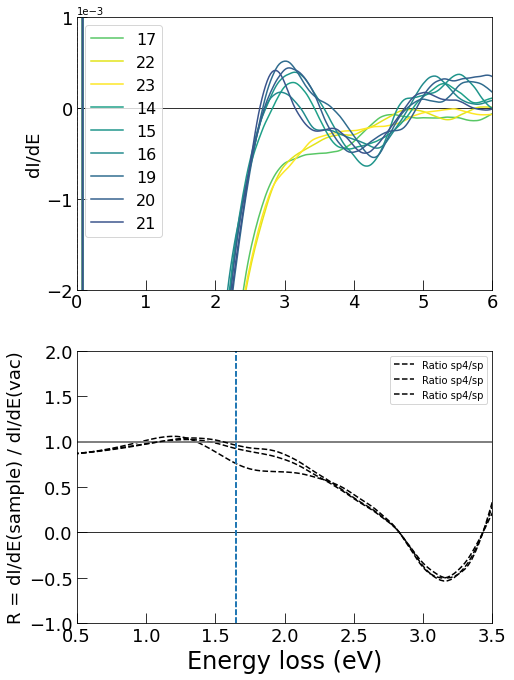

In [5]:
nrows, ncols = 3,1
gs = matplotlib.gridspec.GridSpec(nrows,ncols)
plt.figure(figsize=(ncols*7,nrows*4.5))

cm_subsection = np.linspace(0,1,24) 
colors = [cm.viridis(x) for x in cm_subsection]

hfont = rc('font',**{'family':'sans-serif','sans-serif':['Sans Serif']})
          
for i in range(2):
    ax = plt.subplot(gs[i])
    ax.set_xlim([0,9])
    ax.tick_params(which='major',direction='in',length=7)
    ax.tick_params(which='minor',length=8)
    plt.axhline(y=0, color='black', linewidth=1, alpha=.8)
    plt.axvline(x=0, color='darkgray', linestyle='--', linewidth = 1)
    #plt.axvline(x=dE1, color='darkgray', linestyle='--', linewidth = 1, label='$\Delta$E1' %{'s': dE1})
    
    for j in ([17,22,23]):
        if i == 0:
            p2 = ax.plot(df_dx['x%(i)s'% {"i": j}],df_dx['derivative y%(i)s' %{"i": j}], color=colors[j], label='%(i)s' %{"i": j})

    for j in ([14,15,16,19,20,21]):
        k = j-3
        
        if i == 0:
            p1 = ax.plot(df_dx['x%(i)s'% {"i": j}],df_dx['derivative y%(i)s' %{"i": j}], color=colors[-k], label='%(i)s' %{"i": j})
            ax.set_ylim([-.002, .001])
            ax.set_xlim([0, 6])
            ax.set_ylabel('dI/dE',fontsize=18)
            ax.set_yticks([-0.002, -0.001, 0, 0.001])
            ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
            ax.legend(loc=2, fontsize=16)
        
    for j in ([17,22,23]):   
        if i == 1: 
            ax.axhline(y=1, linestyle='-', color='gray')
            p1 = ax.plot(df_dx['x%(i)s'% {"i": j}], \
                         np.divide(df_dx['derivative y14'],df_dx['derivative y%(i)s'%{"i": j}]), 'k--', label='Ratio sp4/sp'%{"i":j})
            
            ax.axvline(x=1.65, linestyle='--')
            ax.set_ylim([-1, 2])
            ax.set_xlim([.5,3.5])   
            ax.set_ylabel('R = dI/dE(sample) / dI/dE(vac)', fontsize=18)
            ax.set_xlabel('$\Delta$E (eV)', fontsize=218)
            ax.legend()  
    
    if i == 0:
        ax.tick_params(labelbottom=True)
        ax.tick_params(which='major', length= 10, labelsize=18)
        ax.tick_params(which='minor', length= 10, labelsize=10)
    if i == 1:
        ax.set_xlabel('Energy loss (eV)', fontsize=24)
        ax.tick_params(length= 10, labelsize=18)
        ax.tick_params(which='major', length= 10, labelsize=18)
        ax.tick_params(which='minor', length= 10, labelsize=10)
    
plt.tight_layout()
#plt.savefig("Derivatives.pdf")
plt.show()

## 2. Where to add pseudo data? ($\Delta E_{II} = \Delta E_{pd,min}$ )

In [6]:
df_vacmean = pd.DataFrame()
nbins = 200

df_vacmean['x'] = np.linspace(df_vacuum['x_shifted'].min(),df_vacuum['x_shifted'].max(), nbins)
df_vacmean['y'], df_vacmean['sigma'] = binned_statistics(df_vacuum['x_shifted'], (df_vacuum['y']), nbins)[0:2]
df_vacmean['ratio'] = np.divide(df_vacmean['y'], df_vacmean['sigma'])

dE2 = df_vacmean['x'][df_vacmean['ratio'] < 1].min()
dE2 = np.round(dE2)
print("The value for dE_II is", (dE2))

The value for dE_II is 12.0


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


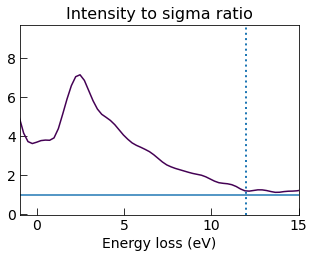

In [7]:
nrows, ncols = 1,1
gs = matplotlib.gridspec.GridSpec(nrows,ncols)
plt.figure(figsize=(ncols*5,nrows*3.5))

cm_subsection = np.linspace(0,1,24) 
colors = [cm.viridis(x) for x in cm_subsection]

hfont = rc('font',**{'family':'sans-serif','sans-serif':['Sans Serif']})

ax = plt.subplot(gs[0])
ax.set_title('Intensity to sigma ratio', fontsize=16)
ax.set_xlim([-1,15])
ax.set_xlabel('Energy loss (eV)', fontsize=14)
ax.tick_params(which='major',direction='in',length=7, labelsize=14)
ax.tick_params(which='minor',length=8)
p1 = ax.plot(df_vacmean['x'],smooth(np.divide(df_vacmean['y'], df_vacmean['sigma']), 10), color=colors[0])
ax.axhline(y=1, linestyle='-')
ax.axvline(x=dE2, linestyle='dotted', linewidth='2')
plt.show()

In [8]:
print('The values of dE1 and dE2:', np.round(dE1,2), "eV and", dE2, "eV")

The values of dE1 and dE2: 2.65 eV and 12.0 eV


### If one wishes to adjust the value for dE1, do it below:

In [9]:
dE1 = 1.8

In [10]:
print('The values of dE1 and dE2:', np.round(dE1,2), "eV and", dE2, "eV")

The values of dE1 and dE2: 1.8 eV and 12.0 eV


## 3. Window and prepare data 
* Drop all data for $\Delta$E $> \Delta$E$_1$
* Calculate the binned mean and variance of the spectra together with the function 'binned_statistics(x,y,nbins)'
* Returns two pd.DataFrames 'df_mean' and 'df_vacmean' with the mean and variance data of the in-sample and in-vacuum spectra



In [11]:
df_window = df[(df['x_shifted'] < dE1) & (df['x_shifted'] > -.5)]
df_window_vacuum = df_vacuum[(df_vacuum['x_shifted'] <= dE1) & (df_vacuum['x_shifted'] > -.5)]

df_mean, df_vacmean = pd.DataFrame(), pd.DataFrame()
nbins = 30

df_mean['x'] = np.linspace(df_window['x_shifted'].min(),df_window['x_shifted'].max(), nbins)
df_mean['y'], df_mean['sigma'] = binned_statistics(df_window['x_shifted'], np.log(df_window['y']), nbins)[0:2]

df_vacmean['x'] = np.linspace(df_window_vacuum['x_shifted'].min(),df_window_vacuum['x_shifted'].max(), nbins)
df_vacmean['y'], df_vacmean['sigma'] = binned_statistics(df_window_vacuum['x_shifted'], np.log(df_window_vacuum['y']), nbins)[0:2]

print("Training data points for DeltaE > DeltaE_I have been removed.")
print("Experimental mean and sigma are calculated.")

Training data points for DeltaE > DeltaE_I have been removed.
Experimental mean and sigma are calculated.


### Create pseudo data for $\Delta$E $ > \Delta$E$_{II}$

In [12]:
min_x = dE2
max_x = 20
N_pseudo = 30

df_pseudo = pd.DataFrame({'x':np.linspace(min_x, max_x, N_pseudo),'y': .5 * np.ones(N_pseudo), \
                    'sigma': .08 * np.ones(N_pseudo)})
df_full = pd.concat([df_mean, df_pseudo])

print('Pseudo data points added for Delta E > DeltaE_II')
print('Training data set "df_full" has been created')

Pseudo data points added for Delta E > DeltaE_II
Training data set "df_full" has been created


## 4. Initialize the NN model

### Create architecture

In [13]:
def make_model(inputs, n_outputs):
    hidden_layer_1 = tf.layers.dense(inputs, 10, activation=tf.nn.sigmoid)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 5, activation=tf.nn.relu)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)
    return output

print("NN is initialized.")

NN is initialized.


## 5. Initialize data for NN training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer

Training points are generated by Monte Carlo sampling; for the set of training points $[\Delta E_i, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $\Delta E_i$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


In [14]:
tf.compat.v1.get_default_graph
tf.compat.v1.disable_eager_execution()

x = tf.placeholder("float", [None, 1], name="x")
y = tf.placeholder("float", [None, 1], name="y")
sigma = tf.placeholder("float", [None, 1], name="sigma")

predictions = make_model(x,1)

df_train_full = df_full
df_train_full = df_train_full.drop_duplicates(subset = ['x']) # Only keep one copy per x-value

df_train, df_test = train_test_split(df_train_full, test_size=0.2)

N_train = len(df_train['x'])
N_test = len(df_test['x'])

train_x = np.copy(df_train['x']).reshape(N_train,1)
train_y = np.copy(df_train['y']).reshape(N_train,1)
train_sigma = (np.copy(df_train['sigma'])).reshape(N_train,1)

test_x = np.copy(df_test['x']).reshape(N_test,1)
test_y = np.copy(df_test['y']).reshape(N_test,1)
test_sigma = np.copy(df_test['sigma']).reshape(N_test,1)



N_pred = 3000
pred_min = -.5
pred_max = 20
predict_x = np.linspace(pred_min,pred_max,N_pred).reshape(N_pred,1)

print("Dataset is split into train subset (80%) and validation subset (20%)")

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Dataset is split into train subset (80%) and validation subset (20%)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


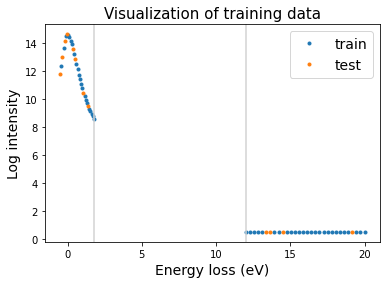

In [15]:
plt.figure(figsize=(6,4))
plt.plot(train_x, train_y, '.', label='train')
plt.plot(test_x, test_y, '.', label='test')
plt.axvline(x=dE1, color='lightgray')
plt.axvline(x=dE2, color='lightgray')
plt.title('Visualization of training data', fontsize=15)
plt.ylabel('Log intensity', fontsize=14)
plt.xlabel('Energy loss (eV)', fontsize=14)
plt.legend(fontsize=14)
plt.show()

## 6. Create MC replicas

In [16]:
Nrep = 1000

train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
        train_rep = np.random.normal(0, train_sigma)
        test_rep = np.random.normal(0, test_sigma)
        train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
        test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
        i+=1 
        
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)

print('MC pseudo data has been created for 1000 replicas')

MC pseudo data has been created for 1000 replicas


# 7. NN training

In [17]:
import time
from datetime import datetime
now = datetime.now()

def function_train():
    
    chi_array = []
    
    cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
    eta = 6e-3
    optimizer = tf.train.RMSPropOptimizer(learning_rate=eta, decay=0.9, momentum=0.0, epsilon=1e-10).minimize(cost)
    saver = tf.train.Saver(max_to_keep=100)
    
    print("Start training on", '%04d'%(N_train), "and validating on",'%0.4d'%(N_test), "samples")
    
    Nrep = 100

    for i in range(Nrep):

        train_y = train_y_reps[:, i].reshape(N_train,1)
        test_y = test_y_reps[:, i].reshape(N_test,1)
        
        ### Train and validate
        prev_test_cost = 0
        prev_epoch = 0
        avg_cost = 0

        array_train = []
        array_test = []

        with tf.Session() as sess:

            sess.run(tf.global_variables_initializer())
            
            training_epochs = 25000
            display_step = 1000

            for epoch in range(training_epochs):

                _, c = sess.run([optimizer, cost], 
                                feed_dict={
                                    x: train_x,
                                    y: train_y,
                                    sigma: train_sigma
                                })

                avg_cost = c
                
                test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})


                if epoch % display_step == 0:
                    print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                    array_train.append(avg_cost)
                    array_test.append(test_cost)
                    saver.save(sess, 'Models/All_models/my-model.ckpt', global_step=epoch , write_meta_graph=False) 

                    
                elif test_cost < prev_test_cost:
                    prev_test_cost = test_cost
                    prev_epoch = epoch

            best_iteration = np.argmin(array_test) 
            best_epoch = best_iteration * display_step
            best_model = 'Models/All_models/my-model.ckpt-%(s)s' % {'s': best_epoch}

            print("Optimization %(i)s Finished! Best model after epoch %(s)s" % {'i': i, 's': best_epoch})
            


            dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
            d_string = now.strftime("%d.%m.%Y")
            t_string = now.strftime("%H:%M:%S")
            
            saver.restore(sess, best_model)
            saver.save(sess, 'Models/Best_models/%(s)s/best_model_%(i)s' % {'s': d_string, 'i': i})


            predictions_values = sess.run(predictions, 
                                feed_dict={
                                    x: train_x,
                                    y: train_y 
                                }) 


            extrapolation = sess.run(predictions,
                                feed_dict={
                                    x: predict_x
                                })
            

        sess.close()
        

        

        a = np.array(train_x).reshape(N_train,)
        b = np.array(train_y).reshape(N_train,)
        c = np.array(predictions_values).reshape(N_train,)
        
        d = array_train
        e = array_test
       
        k = np.array(predict_x).reshape(N_pred,)
        l = np.array(extrapolation).reshape(N_pred,)
        
        path_to_data = 'Data/Results/%(date)s/'% {"date": d_string} 
        
        np.savetxt(path_to_data + 'Predictions_%(k)s.csv' % {"k": i}, list(zip(a,b,c)),  delimiter=',', fmt='%f')
        np.savetxt(path_to_data + 'Cost_%(k)s.csv' % {"k": i}, list(zip(d,e)),  delimiter=',',fmt='%f')
        np.savetxt(path_to_data + 'Extrapolation_%(k)s.csv' % {"k":i}, list(zip(k, l)),  delimiter=',', fmt='%f')
 

## Serial training

In [ ]:
function_train()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Start training on 0048 and validating on 0012 samples
Epoch: 0001 | Training cost= 11223.360351562 | Validation cost= 31408.197265625
Epoch: 1001 | Training cost= 22.278219223 | Validation cost= 87.885040283
Epoch: 2001 | Training cost= 18.380027771 | Validation cost= 82.548797607
Epoch: 3001 | Training cost= 9.959519386 | Validation cost= 48.542179108
